## gotoflux() function

* 09/16: add sigma clipping and plotting  
* fixed on 09/11
* see k2phot_v2 

In [1]:
!python --version

Python 2.7.13 :: Continuum Analytics, Inc.


In [2]:
import os

os.environ['CONDA_DEFAULT_ENV']

'K2phot'

In [3]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
from glob import glob
import getpass
import os 

#fitfiles = glob('new_example_input/*.fits')
#fitfiles = glob('/home/jp/data/transit/c14/*.fits.gz')

## raw

In [32]:
name='/home/jp/data/transit/c14/ktwo248662696-kadenza-lpd-targ.fits.gz'
starname = name.split('/')[-1].split('-')[0][4:-1]
starname

'24866269'

In [33]:
outputpath='output'
starname='24866269'

In [37]:
fname='lightcurve_raw_'+starname+'.txt'
join(outputpath,starname,fname)

'output/24866269/lightcurve_raw_24866269.txt'

In [34]:
import pandas as pd
from astropy.stats import sigma_clip
from os.path import join

def load_df(outputpath,starname,sigma_upper=10,sigma_lower=2):
    fname='lightcurve_raw_'+starname+'.txt'
    txtfile=join(outputpath,starname,fname)
    df = pd.read_csv(txtfile, skiprows=1, delimiter=' ', names=['t','f','x','y'])
    df['f_clip'] = sigma_clip(df.f, sigma_upper=sigma_upper,sigma_lower=sigma_lower)
    df['fmed'] = df.f_clip.apply(lambda x: x/np.nanmedian(df.f_clip))
    df['f_mask'] = df.fmed[df.fmed.apply(lambda x: (x > 0.9) & (x < 1.1))]
    df.head()
    return df

df=load_df(outputpath,starname)

In [35]:
df.head()

,t,f,x,y,f_clip,fmed,f_mask
0,3072.723055,3818319.0,572.403585,966.464704,3818319.0,0.990996,0.990996
1,3072.743489,3821228.0,572.406562,966.464730,3821228.0,0.991751,0.991751
2,3072.763923,3824836.0,572.409431,966.463025,3824836.0,0.992687,0.992687
3,3072.784356,3827722.0,572.413336,966.462434,3827722.0,0.993436,0.993436
4,3072.804790,3830503.0,572.419457,966.461292,3830503.0,0.994158,0.994158


clipped datapoints: 39


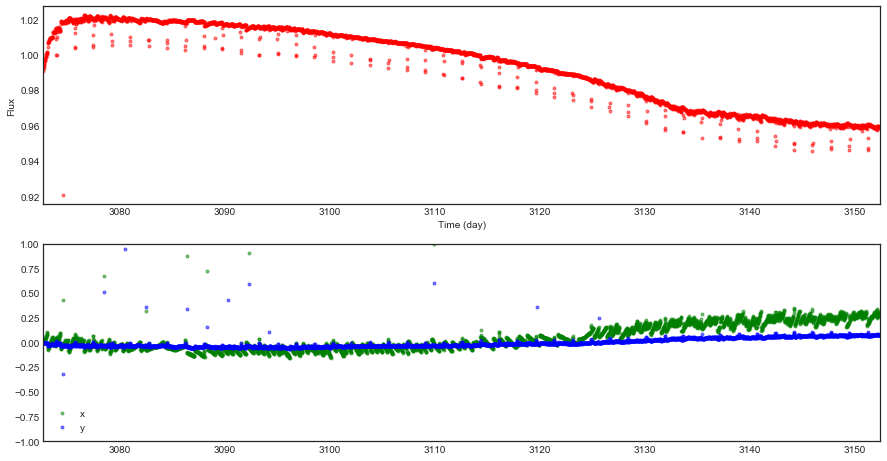

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

def plot_f_xy(df):
    fig, ax = plt.subplots(2,1,figsize=(15,8))
    #ax[0].plot(df.t, df.f_clip,'.', alpha=0.5, color='r', marker='.')
    ax[0].plot(df.t, df.f_mask,'.', alpha=0.5, color='r', marker='.')
    ax[0].set_ylabel('Flux')
    ax[0].set_xlabel('Time (day)')
    #ax[0].set_ylim([np.median(df.fmed)-0.1,np.median(df.fmed)+0.1])
    ax[0].set_xlim([df.t.iloc[0],df.t.iloc[-1]])
    #centroid drift
    ax[1].plot(df.t, df.x.apply(lambda x: x-df.x.iloc[0]),'.', alpha=0.5, color='g', marker='.', label='x')
    ax[1].plot(df.t, df.y.apply(lambda x: x-df.y.iloc[0]),'.', alpha=0.5, color='b', marker='.', label='y')
    ax[1].set_ylim([-1,1])
    ax[1].set_xlim([df.t.iloc[0],df.t.iloc[-1]])
    plt.legend()

    print('clipped datapoints: {}'.format(np.isnan(df.f_mask).sum()))
    
plot_f_xy(df)

In [8]:
x=df.x
y=df.y
f=df.f/np.median(df.f)
t=df.t

#design matrix
X = np.c_[x,y,x*y,x**2,y**2,np.ones_like(x)]

In [9]:
#coeff
beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),f)

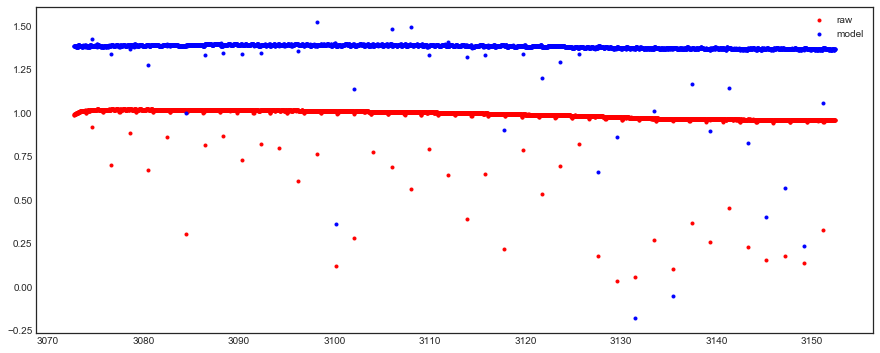

In [10]:
fig,ax=pl.subplots(1,1,figsize=(15,6))
f_hat=np.dot(X,beta)
ax.plot(t,f,'r.',label='raw')
ax.plot(t,f_hat,'b.',label='model')
ax.legend()

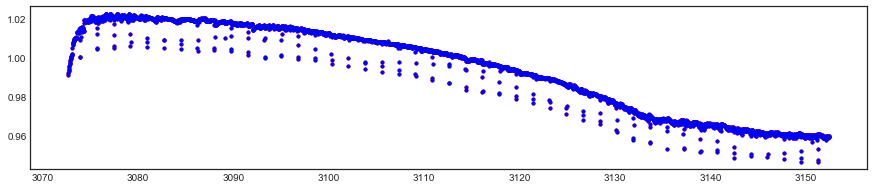

In [13]:
#sigma clipping
from astropy.stats import sigma_clip

def astropy_sigma_clip(t,f,x,y,sigma=3,showfig=True):
    fmask= sigma_clip(f, sigma=sigma).mask
    xmask= sigma_clip(x, sigma=sigma).mask
    ymask= sigma_clip(y, sigma=sigma).mask

    zz = np.c_[fmask, xmask, ymask]
    # idx = zz.sum(axis=1) != 0
    # idx.sum()
    mask=zz.any(axis=1)
    if showfig:
        fig, ax = pl.subplots(1,1,figsize=(15,3))
        ax.plot(t,f,'r.',label='raw')
        ax.plot(t[~mask],f[~mask],'b.',label='clipped')
        #ax.set_ylim(0.98,1.01)
    t,f,x,y=t[~mask],f[~mask],x[~mask],y[~mask]
    return t,f,x,y

t,f,x,y=astropy_sigma_clip(t,f,x,y,sigma=3,showfig=True)

In [14]:
#model
X = np.c_[x,y,x*y,x**2,y**2,np.ones_like(x)]
beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),f)

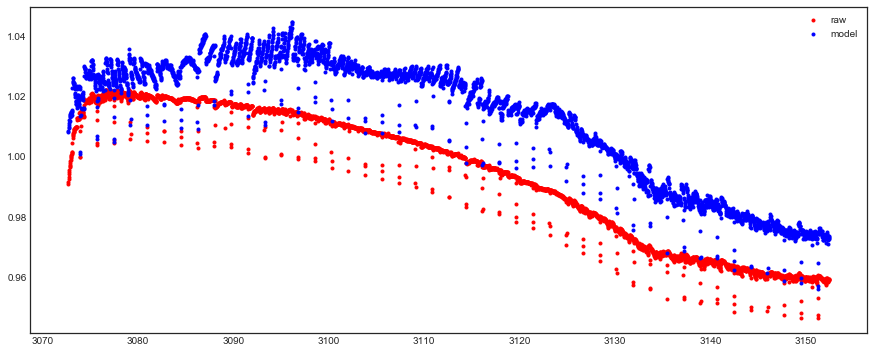

In [15]:
fig,ax=pl.subplots(1,1,figsize=(15,6))
f_hat=np.dot(X,beta)
ax.plot(t,f,'r.',label='raw')
ax.plot(t,f_hat,'b.',label='model')
ax.legend()

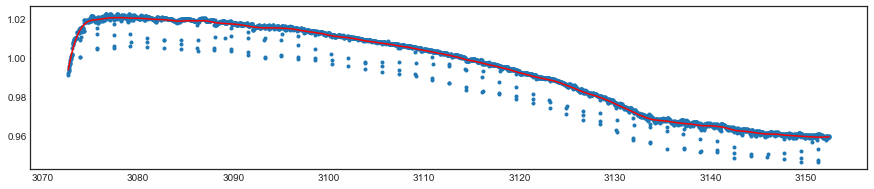

In [20]:
#fit spline
from scipy.interpolate import Rbf

def fit_rbf(t,f,showfig=True):
    rbfi = Rbf(t, f, function='quintic', smooth=100)
    if showfig:
        fig, ax = pl.subplots(1,1,figsize=(15,3))
        ax.plot(t, f, '.')
        ax.plot(t, rbfi(t), 'r-')
    return t,rbfi(t)

t_rbf,f_rbf=fit_rbf(t,f)

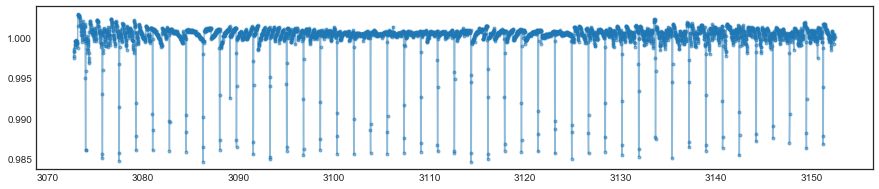

In [22]:
#detrended lc

fig, ax = pl.subplots(1,1,figsize=(15,3))

f_cd = f / f_rbf
pl.plot(t,f_cd,'.-', alpha=0.5 )
#ax.set_ylim(0.98,1.01)

In [23]:
#new model
X = np.c_[x,y,x*y,x**2,y**2,np.ones_like(x)]
beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),f_cd)

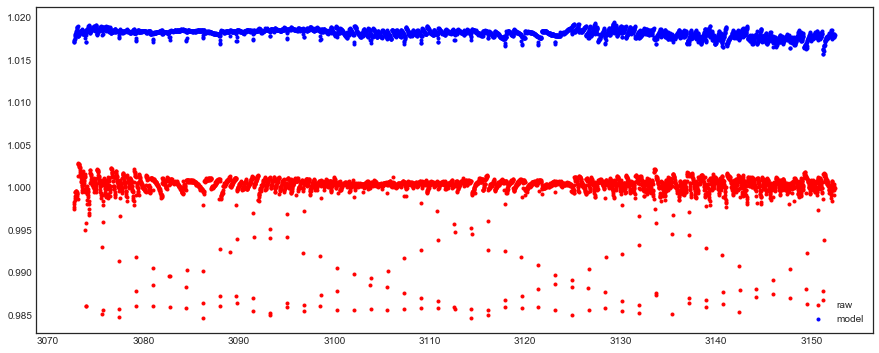

In [24]:
fig,ax=pl.subplots(1,1,figsize=(15,6))
f_hat=np.dot(X,beta)

ax.plot(t,f_cd,'r.',label='raw')
ax.plot(t,f_hat,'b.',label='model')
ax.legend()

(0.98, 1.01)

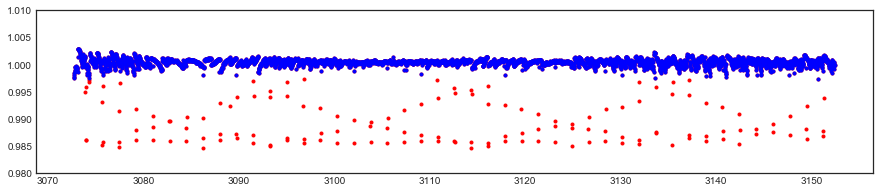

In [25]:
#out of transit
xx=sigma_clip(f_cd, sigma_lower=5, sigma_upper=5)
tt,ff=t[~xx.mask],f_cd[~xx.mask]
x,y=x[~xx.mask],y[~xx.mask]

fig, ax = pl.subplots(1,1,figsize=(15,3))

ax.plot(t,f_cd,'r.',label='raw')
ax.plot(tt,ff,'b.',label='clipped')
ax.set_ylim(0.98,1.01)

In [26]:
#new model
X = np.c_[x,y,x*y,x**2,y**2,np.ones_like(x)]
beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),ff)

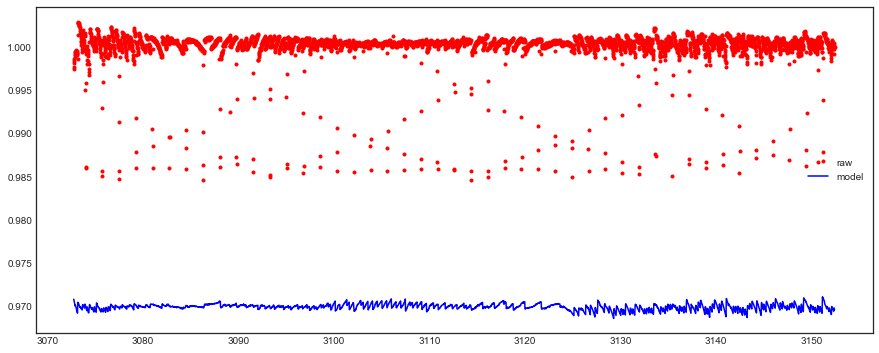

In [27]:
fig,ax=pl.subplots(1,1,figsize=(15,6))
f_hat=np.dot(X,beta)

ax.plot(t,f_cd,'r.',label='raw')
ax.plot(tt,f_hat,'b-',label='model')
ax.legend()

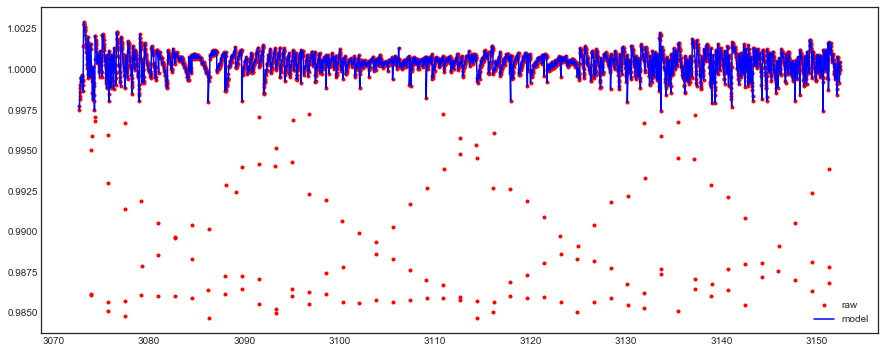

In [28]:
fig,ax=pl.subplots(1,1,figsize=(15,6))
f_hat=np.dot(X,beta)

ax.plot(t,f_cd,'r.',label='raw')
ax.plot(tt,ff,'b-',label='model')
ax.legend()

## least squares without bias

In [29]:
#new model
X = np.c_[x,y,x*y,x**2,y**2]
beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),ff)

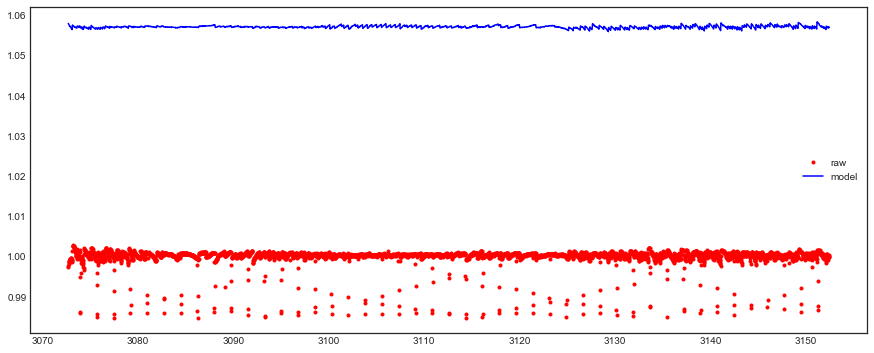

In [30]:
fig,ax=pl.subplots(1,1,figsize=(15,6))
f_hat=np.dot(X,beta)

ax.plot(t,f_cd,'r.',label='raw')
ax.plot(tt,f_hat,'b-',label='model')
ax.legend()

## MLE without bias

In [ ]:
from scipy import optimize as op

X = np.c_[x,y,x*y,x**2,y**2]

#sigma as a free parameter
def log_like(theta, X, y):
    logsigma = theta[-1]
    sigma = np.exp(logsigma)
    y_model = (theta[:-1]*X).sum(axis=1)
    return -0.5 * np.sum(np.log(sigma**2) + (y-y_model)**2 / sigma**2)

x0 = [0,0,0,0,0,np.log((np.std(ff)))]

args = (X, ff)
nll = lambda *x: -log_like(*x)

In [ ]:
nll(x0, X, ff)

In [ ]:
opt = op.minimize(nll, x0, args=args, method='powell')

In [ ]:
print(opt.success)
print(opt.x)

In [ ]:
fig,ax = pl.subplots(1,1,figsize=(15,6))
f_hat=(opt.x[:-1]*X).sum(axis=1)

ax.plot(tt,ff,'r.',label='raw')
ax.plot(tt,f_hat,'b.',label='model')
ax.legend()

Making sigma a free parameter allows the optimizer to assign small number at the expense of fitting the model. In contrast to LSE which assumes equal constant sigma, it is forced to explain all (overfit) the data.

In [ ]:
#sigma
np.exp(opt.x[-1])

In [ ]:
np.std(ff)

## MCMC with fixed small sigma

In [ ]:
from scipy import optimize as op

X = np.c_[x,y,x*y,x**2,y**2]

#sigma as a free parameter
def log_like(theta, X, y):
    logsigma = -100
    sigma = np.exp(logsigma)
    y_model = (theta*X).sum(axis=1)
    return -0.5 * np.sum(np.log(sigma**2) + (y-y_model)**2 / sigma**2)

x0 = [0,0,0,0,0]

args = (X, ff)
nll = lambda *x: -log_like(*x)

In [ ]:
import emcee
from tqdm import tqdm

nwalkers=100
ndim = len(x0)
nsteps=1000

sampler.reset
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_like, args=args)
x0ball = [np.random.normal(loc=i,scale=0.01,size=nwalkers) for i in x0]
#x0ball = [np.random.normal(loc=i,scale=0.01,size=nwalkers) for i in opt.x]
x0ball = np.array(x0ball).reshape(nwalkers, ndim)

In [ ]:
for pos,lp,_ in tqdm(sampler.sample(x0ball,iterations=nsteps)):
    pass

In [ ]:
sampler.chain.shape

In [ ]:
for post,lp,_ in tqdm(sampler.sample(pos,iterations=nsteps)):
    pass

In [ ]:
trace = sampler.chain
nburn=1000
labels='x,y,x*y,x2,y2'.split(',')
fig, axs = plt.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)
[axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(trace.T)]
[axs.flat[i].set_ylabel(l) for i,l in enumerate(labels)]

plt.xlabel('nsteps')

In [ ]:
import corner

burn=1000
#theta_hat=sampler.flatchain[np.argmax(sampler.flatlnprobability)]

fc=trace[:,burn:,:].reshape(nsteps*nwalkers,ndim)
corner.corner(fc, labels=labels, 
              quantiles=[0.16, 0.5, 0.84], 
              truths=beta,#theta_hat,
              show_titles=True, title_kwargs={"fontsize": 12});

In [ ]:
theta_hat=sampler.flatchain[np.argmax(sampler.flatlnprobability)]

fig,ax = pl.subplots(1,1,figsize=(15,6))
f_hat=(theta_hat*X).sum(axis=1)

ax.plot(tt,ff,'r.',label='raw')
ax.plot(tt,f_hat,'b.',label='model')
ax.legend()

## MCMC with varying sigma

In [ ]:
from scipy import optimize as op

X = np.c_[x,y,x*y,x**2,y**2]

#sigma as a free parameter
def log_like(theta, X, y):
    logsigma = theta[-1]
    sigma = np.exp(logsigma)
    y_model = (theta[:-1]*X).sum(axis=1)
    return -0.5 * np.sum(np.log(sigma**2) + (y-y_model)**2 / sigma**2)

x0 = [0,0,0,0,0,np.log((np.std(ff)))]

args = (X, ff)
nll = lambda *x: -log_like(*x)

In [ ]:
import emcee
from tqdm import tqdm

nwalkers=100
ndim = len(x0)
nsteps=1000

sampler.reset
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_like, args=args)
#x0ball = [np.random.normal(loc=i,scale=0.01,size=nwalkers) for i in x0]
x0ball = [np.random.normal(loc=i,scale=0.01,size=nwalkers) for i in opt.x]
x0ball = np.array(x0ball).reshape(nwalkers, ndim)

In [ ]:
for pos,lp,_ in tqdm(sampler.sample(x0ball,iterations=nsteps)):
    pass

In [ ]:
sampler.chain.shape

In [ ]:
for post,lp,_ in tqdm(sampler.sample(pos,iterations=nsteps)):
    pass

In [ ]:
trace = sampler.chain
nburn=1000
labels='x,y,x*y,x2,y2,sigma'.split(',')
fig, axs = plt.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)
[axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(trace.T)]
[axs.flat[i].set_ylabel(l) for i,l in enumerate(labels)]

plt.xlabel('nsteps')

In [ ]:
import corner

burn=1000
theta_hat=sampler.flatchain[np.argmax(sampler.flatlnprobability)]
#f_hat=np.dot(X,beta)
fc=trace[:,burn:,:].reshape(nsteps*nwalkers,ndim)
corner.corner(fc, labels=labels, 
              quantiles=[0.16, 0.5, 0.84], 
              truths=np.concatenate((beta,[0]),axis=0),#theta_hat,
              show_titles=True, title_kwargs={"fontsize": 12});

In [ ]:
fig,ax = pl.subplots(1,1,figsize=(15,6))
f_hat=(theta_hat[:-1]*X).sum(axis=1)

ax.plot(tt,ff,'r.',label='raw')
ax.plot(tt,f_hat,'b.',label='model')
ax.legend()

In [ ]:
theta_hat=sampler.flatchain[np.argmax(sampler.flatlnprobability)]
#c.f.sampler.flatchain[np.argmax(lp)]
theta_hat

In [ ]:
fig,ax = pl.subplots(1,1,figsize=(15,6))
f_hat=(theta_hat[:-1]*X).sum(axis=1)

ax.plot(tt,ff,'r.',label='raw')
ax.plot(tt,f_hat,'b.',label='model')
ax.legend()

In [ ]:
fig = plt.figure(figsize=(12,3))
for i in range(ndim):
    plt.subplot(1,len(labels),i+1)
    plt.hist(trace[:,i], 10, histtype="step")
    yl = plt.ylim()
    #plt.vlines(theta_true[i], yl[0], yl[1], color='blue', lw=3, alpha=0.25, label='true')
    #plt.title("{}".format(labels[i]))
    plt.legend()

In [ ]:
#get out of transit lc
def get_tns(t, p, t0):

    idx = t != 0
    t = t[idx]

    while t0-p > t.min():
        t0 -= p
    if t0 < t.min():
        t0 += p

    tns = [t0+p*i for i in range(int((t.max()-t0)/p+1))]

    while tns[-1] > t.max():
        tns.pop()

    while tns[0] < t.min():
        tns = tns[1:]

    return tns

In [ ]:
#get period
from astropy.stats import LombScargle

frequency, power = LombScargle(t, f).autopower(nyquist_factor=10,
                                                minimum_frequency=0.1,
                                                maximum_frequency=3)

In [ ]:
idx1 = frequency > 1
idx2 = np.argmax(power[idx1])
peak = 1./frequency[idx1][idx2]

fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(1./frequency, power, '-',label='y')

ax.set(xlim=(0.5, 3),
#         , ylim=(0, 0.01),
   xlabel='period (days)',
   ylabel='Lomb-Scargle Power')
ax.vlines(peak, *ax.get_ylim(), linestyles='dotted', colors='r')
ax.legend()

print(peak)

In [ ]:
2*peak

In [ ]:
p=1.7555 #2*peak
t0=3074

tns=get_tns(t, p, t0)

In [ ]:
#get out of transit lc

intransit = np.zeros_like(t).astype(bool)
t14=0.1

for tn in tns:
    idx = (t > tn - t14/2.) & (t < tn + t14/2.)
    intransit = np.logical_or(intransit, idx)
    
fig, ax = pl.subplots(1,1,figsize=(15,3))
ax.plot(t[~intransit], f[~intransit], '.')

In [ ]:
#fit spline

from scipy.interpolate import Rbf
rbfi = Rbf(t[~intransit], f[~intransit], function='quintic', smooth=100)

fig, ax = pl.subplots(1,1,figsize=(15,3))
ax.plot(t[~intransit], f[~intransit], '.')
ax.plot(t, rbfi(t), 'r-')

In [ ]:
#detrended out of transit lc

fig, ax = pl.subplots(1,1,figsize=(15,3))

y_cs=f - rbfi(t) + 1.0
# ax.plot(t, y_cs, '.-', alpha=0.5)
# ax.set_ylim(0.98,1.01)
pl.plot(t[~intransit],y_cs[~intransit],'.-', alpha=0.5 )
ax.set_ylim(0.98,1.01)

In [ ]:
def get_tns(t, p, t0):

    idx = t != 0
    t = t[idx]

    while t0-p > t.min():
        t0 -= p
    if t0 < t.min():
        t0 += p

    tns = [t0+p*i for i in range(int((t.max()-t0)/p+1))]

    while tns[-1] > t.max():
        tns.pop()

    while tns[0] < t.min():
        tns = tns[1:]

    return tns


def extract_individual(star, p, t0, width=1):

    t, f = star.time, star.flux
    idx = np.isfinite(t) & np.isfinite(f)
    t, f = t[idx], f[idx]

    tns =  get_tns(t, p, t0)

    transits = []
    for i,tn in enumerate(tns):
        idx = (t > tn - width/2.) & (t < tn + width/2.)
        if idx.sum() == 0:
            continue
        ti = t[idx].tolist()
        fi = f[idx].tolist()
        transits.append((ti,fi))

    return transits

def fold(t, f, p, t0, width=0.4, clip=False, bl=False, t14=0.2):
    tns = get_tns(t, p, t0)
    tf, ff = np.empty(0), np.empty(0)
    for i,tn in enumerate(tns):
        idx = (t > tn - width/2.) & (t < tn + width/2.)
        ti = t[idx]-tn
        fi = f[idx]
        fi /= np.nanmedian(fi)
        if bl:
            idx = (ti < -t14/2.) | (ti > t14/2.)
            assert np.isfinite(ti[idx]).all() & np.isfinite(fi[idx]).all()
            assert idx.sum() > 0
            try:
                res = sm.RLM(fi[idx], sm.add_constant(ti[idx])).fit()
                if np.abs(res.params[1]) > 1e-2:
                    print('bad data probably causing poor fit')
                    print('transit {} baseline params: {}'.format(i, res.params))
                    continue
                model = res.params[0] + res.params[1] * ti
                fi = fi - model + 1
            except:
                print("error computing baseline for transit {}".format(i))
                print("num. points: {}".format(idx.sum()))
                print(ti)
        tf = np.append(tf, ti)
        ff = np.append(ff, fi / np.nanmedian(fi))
    idx = np.argsort(tf)
    tf = tf[idx]
    ff = ff[idx]
    if clip:
        fc = sigma_clip(ff, sigma_lower=10, sigma_upper=2)
        tf, ff = tf[~fc.mask], ff[~fc.mask]
    return tf, ff

In [ ]:
t,f=df.t, df.f_mask#df.fmed

p=1.7555
t0=3074
tns=get_tns(t, p, t0)

In [ ]:
fig, ax = pl.subplots(1,1,figsize=(15,3))
ax.plot(t, f, '.')
ax.vlines(tns, 0.98, 0.99)

In [ ]:
intransit = np.zeros_like(t).astype(bool)
t14=0.1

for tn in tns:
    idx = (t > tn - t14/2.) & (t < tn + t14/2.)
    intransit = np.logical_or(intransit, idx)
    
fig, ax = pl.subplots(1,1,figsize=(15,3))
ax.plot(t[~intransit], f[~intransit], '.')

In [ ]:
t=pd.DataFrame({'t':t,'f':f}).dropna()['t']
f=pd.DataFrame({'t':t,'f':f}).dropna()['f']

#t, f = tf[~fc.mask], ff[~fc.mask]

In [ ]:
from scipy.interpolate import Rbf
rbfi = Rbf(t[~intransit], f[~intransit], function='quintic', smooth=100)

fig, ax = pl.subplots(1,1,figsize=(15,3))
ax.plot(t[~intransit], f[~intransit], '.')
ax.plot(t, rbfi(t), 'r-')

In [ ]:
fig, ax = pl.subplots(1,1,figsize=(15,3))
ax.plot(t, f - rbfi(t) + 1.0, '.-', alpha=0.5)
ax.set_ylim(0.98,1.01)

In [ ]:
fig, ax = pl.subplots(1,1,figsize=(15,3))
ax.plot(t, f - rbfi(t) + 1.0, '.-', alpha=0.5)
ax.set_ylim(0.98,1.01)

In [ ]:
from gatspy.periodic import LombScargleFast

#t,f=df.t, df.f
model = LombScargleFast().fit(t, f - rbfi(t) + 1.0)
periods, power = model.periodogram_auto(nyquist_factor=100)

In [ ]:
periods[periods > 1][np.argmax(power[periods > 1])]

In [ ]:
#get positive periods
idx1 = periods > 1
#
idx2 = np.argmax(power[idx1])
peak = periods[idx1][idx2]

fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(periods, power, 'k-')
ax.set(xlim=(0.5, 3),
#         , ylim=(0, 0.01),
   xlabel='period (days)',
   ylabel='Lomb-Scargle Power')
ax.vlines(peak, *ax.get_ylim(), linestyles='dotted', colors='r')

print(peak)

Using GP

In [ ]:
import george

george.__version__

In [2]:
pl.plot(df.x,df.f,'bo')

NameError: name 'pl' is not defined

In [ ]:
from george.kernels import ExpSquaredKernel

kernel = ExpSquaredKernel(1.0)
gp = george.GP(kernel)

fc/=np.median(fc)
gp.compute(tc, np.nanstd(fc))

# Compute the log likelihood.
print(gp.lnlikelihood(fc))

In [ ]:
mu, cov = gp.predict(fc,tc)
std = np.sqrt(np.diag(cov))

In [ ]:
fig, ax = pl.subplots(1,1,figsize=(15,3))
ax.plot(tc,fc)
ax.plot(tc,mu,'r-',lw=3)
ax.fill_between(tc, mu-std,mu+std, color='r', alpha=0.01)

In [ ]:
fig, ax = pl.subplots(1,1,figsize=(15,3))
ax.plot(t,fc-mu + 1.0,'r-',lw=2)

n=1
ax.fill_between(t, fc-mu-n*std+1.0,fc-mu+n*std+1.0, color='k', alpha=0.3)
ax.set_ylim(0.98,1.01)

In [ ]:
#periodogram peak
tf, ff = fold(t, f, peak, t0, width=0.5, clip=False, bl=False, t14=t14)

fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(tf, ff, '.')

In [ ]:
#guess
p=1.7555
tf, ff = fold(t, f, p, t0, width=0.5, clip=False, bl=False, t14=t14)

fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(tf, ff, '.')

In [ ]:
from pytransit import MandelAgol

MA = MandelAgol()

def model(theta, t):
    
    k,t0,p,a,i,u1,u2,_,_,_,_,_ = theta
    model = MA.evaluate(t, k, (u1,u2), t0, p, a, i)
    
    return model

def model_s(theta, xcenter, ycenter, t):
    offset = np.ones(len(t))
    s = (np.array(theta)*np.c_[xcenter, ycenter, offset, t]).sum(axis=1)
    return s

def baseline(theta, t):
    ti = t - t.mean()
    c0,c1,c2,c3 = theta[-4:]
    return c0 + c1 * ti + c2 * ti**2 + c3 * ti**3
    
    
def lnlike(theta, t, f):
    
    k,t0,p,a,i,u1,u2,sig,c0,c1,c2,c3 = theta
    m = model(theta, t) + baseline(theta, t)
    resid = f - m
    inv_sigma2 = 1.0/(sig**2)

    return -0.5*(np.sum((resid)**2*inv_sigma2 - np.log(inv_sigma2)))


def lnprob(theta, t, f):
    
    if np.any(theta[:-4] < 0):
        return -np.inf
    if theta[4] > np.pi/2.:
        return -np.inf

    ll = lnlike(theta, t, f)
    return ll if np.isfinite(ll) else -np.inf


def scaled_a(p, t14, k, i=np.pi/2.):
    numer = np.sqrt( (k + 1) ** 2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

In [ ]:
m=model_s([1,1,1,1], df.x, df.y, df.t)
plt.plot(df.t,m)

In [ ]:
len(xc)

In [ ]:
len(yc)

In [ ]:
len(fc)

In [ ]:
len(tc)

In [ ]:
p=1.7555
t0=3074
t14 = 0.5
k = np.sqrt(1-0.985)
i = np.pi/2.
a = scaled_a(p, t14, k, i)
u1, u2 = 0.2, 0.2
sig = f.std()
lna = 1e-1
lntau = 1
initial = [k,t0,p,a,i,u1,u2,sig,0,0,0,0]
args = (t, f)

nlp = lambda *args: -lnprob(*args)

import scipy.optimize as op

opt = op.minimize(nlp, initial, args=args, method='nelder-mead')
print(opt.success)
print(opt.x)

In [ ]:
opt.x[1], opt.x[2]

In [ ]:
t0, p = opt.x[1], opt.x[2]

tf, ff = fold(t, f, p, t0)
ff /= np.median(ff)

fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(tf, ff, '.')
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')

Worse results. Stick to guessed period.

In [3]:
import gzip
loc='output/'
with gzip.GzipFile(os.path.join(loc,'chain.npy.gz'), "r") as g:
    chain=np.load(g)

NameError: name 'os' is not defined

In [4]:
#chain = sampler.chain
ndim = len(initial)
nwalkers = 8 * ndim

labels = ['${}$'.format(i) for i in r'k,t_0,P,a,i,u_1,u_2,\sigma,c_0,c_1,c_2,c_3'.split(',')]

fig, axs = pl.subplots(ndim, 1, figsize=(15,ndim), sharex=True)
[axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain.T)]
for i,ax in enumerate(axs):
    ax.set_ylabel(labels[i], fontsize=20)
fig.tight_layout()

NameError: name 'initial' is not defined

In [ ]:
burn = 1000
thin = 1
fc = chain[:,burn::thin,:].reshape([-1,chain.shape[-1]])

param_names= 'k,t_0,P,a,i,u_1,u_2,\sigma,c_0,c_1,c_2,c_3'.split(',')
pd.set_option('display.precision',4)
df = pd.DataFrame(data=fc.copy(), columns=param_names)
df.describe()

In [ ]:
import corner

hist_kwargs = dict(lw=2, alpha=0.5)
title_kwargs = dict(fontdict=dict(fontsize=12))

corner.corner(fc, 
              labels=labels,
#                   truths=truths,
              hist_kwargs=hist_kwargs,
              title_kwargs=title_kwargs,
              show_titles=True, 
              quantiles=[0.16,0.5,0.84],
              title_fmt='.4f') #     fig.tight_layout()

In [ ]:
#sampling
nsamples=100

mod_best = [model(th, t) for th in fc[np.random.randint(0, fc.shape[0], size=nsamples)]]
bl_best = [baseline(th, t) for th in fc[np.random.randint(0, fc.shape[0], size=nsamples)]]

In [ ]:
med = np.median(fc, axis=0)
t0 = med[1]
p = med[2]

tf, ff = fold(t, f, p, t0)
ff /= np.median(ff)

tm, fm = fold(t, mod_best[0], p, t0)
fm /= np.median(fm)

fig, ax = pl.subplots(1,1,figsize=(15,5))
ax.plot(tf, ff, 'b.')
ax.plot(tm, fm, 'r-')

## centroid detrended

In [5]:
import pandas as pd
from astropy.stats import sigma_clip

d = glob(os.path.join(folders[1],'lcs/*.txt'))[0]
df = pd.read_csv(d, skiprows=1, delimiter=' ', names=['t','f'])
f_ = sigma_clip(df.f,sigma=2)
df['f_clip'] = f_

NameError: name 'glob' is not defined

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

fig, ax = plt.subplots(1,1,figsize=(15,3))
ax.plot(df.t, df.f_clip,'.', alpha=0.5, color='r', marker='.')
ax.set_ylabel('Flux')
ax.set_xlabel('Time (day)')
ax.set_xlim([df.t.iloc[0],df.t.iloc[-1]])

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

fig, ax = plt.subplots(1,1,figsize=(15,3))
#ax.plot(df.t, df.f,'.', alpha=0.5, color='k', marker='o')
ax.plot(df.t, df.f_clip,'.', alpha=0.5, color='r', marker='.')
ax.set_ylabel('Flux')
ax.set_xlabel('Time (day)')
ax.set_xlim([3100,3110])
ax.set_ylim([-0.004,0.001])

In [ ]:
from gatspy.periodic import LombScargleFast

t,f=df.t, df.f
model = LombScargleFast().fit(t, f)
periods, power = model.periodogram_auto(nyquist_factor=100)

In [ ]:
periods[periods > 1][np.argmax(power[periods > 1])]

In [ ]:
#get positive periods
idx1 = periods > 1
#
idx2 = np.argmax(power[idx1])
peak = periods[idx1][idx2]

fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(periods, power, 'k-')
ax.set(xlim=(0.5, 3),
#         , ylim=(0, 0.01),
   xlabel='period (days)',
   ylabel='Lomb-Scargle Power')
ax.vlines(peak, *ax.get_ylim(), linestyles='dotted', colors='r')

In [ ]:
idx = (3100 < t) & (t < 3110)
tsub, fsub = t[idx], f[idx]
idx = fsub < np.median(fsub) - 0.5 * np.std(fsub)
t0 = np.median(tsub[idx])

fig, ax = plt.subplots(1,1,figsize=(15,3))
ax.plot(tsub, fsub, '.')
ax.vlines(t0, *ax.get_ylim())

In [ ]:
#import simfit
#tf, ff = simfit.util.fold(t, f, peak, t0)

def get_tns(t, p, t0):

    idx = t != 0
    t = t[idx]

    while t0-p > t.min():
        t0 -= p
    if t0 < t.min():
        t0 += p

    tns = [t0+p*i for i in range(int((t.max()-t0)/p+1))]

    while tns[-1] > t.max():
        tns.pop()

    while tns[0] < t.min():
        tns = tns[1:]

    return tns


def extract_individual(star, p, t0, width=1):

    t, f = star.time, star.flux
    idx = np.isfinite(t) & np.isfinite(f)
    t, f = t[idx], f[idx]

    tns =  get_tns(t, p, t0)

    transits = []
    for i,tn in enumerate(tns):
        idx = (t > tn - width/2.) & (t < tn + width/2.)
        if idx.sum() == 0:
            continue
        ti = t[idx].tolist()
        fi = f[idx].tolist()
        transits.append((ti,fi))

    return transits

def fold(t, f, p, t0, width=0.4, clip=False, bl=False, t14=0.2):
    tns = get_tns(t, p, t0)
    tf, ff = np.empty(0), np.empty(0)
    for i,tn in enumerate(tns):
        idx = (t > tn - width/2.) & (t < tn + width/2.)
        ti = t[idx]-tn
        fi = f[idx]
        fi /= np.nanmedian(fi)
        if bl:
            idx = (ti < -t14/2.) | (ti > t14/2.)
            assert np.isfinite(ti[idx]).all() & np.isfinite(fi[idx]).all()
            assert idx.sum() > 0
            try:
                res = sm.RLM(fi[idx], sm.add_constant(ti[idx])).fit()
                if np.abs(res.params[1]) > 1e-2:
                    print('bad data probably causing poor fit')
                    print('transit {} baseline params: {}'.format(i, res.params))
                    continue
                model = res.params[0] + res.params[1] * ti
                fi = fi - model + 1
            except:
                print("error computing baseline for transit {}".format(i))
                print("num. points: {}".format(idx.sum()))
                print(ti)
        tf = np.append(tf, ti)
        ff = np.append(ff, fi / np.nanmedian(fi))
    idx = np.argsort(tf)
    tf = tf[idx]
    ff = ff[idx]
    if clip:
        fc = sigma_clip(ff, sigma_lower=10, sigma_upper=2)
        tf, ff = tf[~fc.mask], ff[~fc.mask]
    return tf, ff

tf, ff = fold(t, f, peak, t0)


fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(tf, ff, '.')

In [ ]:
import pandas as pd

d = glob(os.path.join(folders[1],'folded_*.txt'))[0]

In [ ]:
df = pd.read_csv(d, skiprows=1, delimiter=' ', names=['t','f'])
# f_ = sigma_clip(df.f,sigma=2)
# df['f_clip'] = f_
df.head()

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15,3))
ax.plot(df.t, df.f,'.', alpha=0.1, color='k', marker='.')
ax.set_ylabel('Flux')
ax.set_xlabel('Time (day)')
#ax.set_xlim([df.t.iloc[0],df.t.iloc[-1]])
ax.set_xlim([1,1.3])

In [ ]:
from pytransit import MandelAgol

In [ ]:
from pytransit import MandelAgol

MA = MandelAgol()


def model(theta, t):
    
    k,t0,p,a,i,u1,u2,_,_,_,_,_ = theta
    model = MA.evaluate(t, k, (u1,u2), t0, p, a, i)
    
    return model


def baseline(theta, t):
    ti = t - t.mean()
    c0,c1,c2,c3 = theta[-4:]
    return c0 + c1 * ti + c2 * ti**2 + c3 * ti**3
    
    
def lnlike(theta, t, f):
    
    k,t0,p,a,i,u1,u2,sig,c0,c1,c2,c3 = theta
    m = model(theta, t) + baseline(theta, t)
    resid = f - m
    inv_sigma2 = 1.0/(sig**2)

    return -0.5*(np.sum((resid)**2*inv_sigma2 - np.log(inv_sigma2)))


def lnprob(theta, t, f):
    
    if np.any(theta[:-4] < 0):
        return -np.inf
    if theta[4] > np.pi/2.:
        return -np.inf

    ll = lnlike(theta, t, f)
    return ll if np.isfinite(ll) else -np.inf


def scaled_a(p, t14, k, i=np.pi/2.):
    numer = np.sqrt( (k + 1) ** 2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

In [ ]:
p = peak
t14 = 0.10
k = np.sqrt(1-0.993)
i = np.pi/2.
a = scaled_a(p, t14, k, i)
u1, u2 = 0.2, 0.2
sig = f.std()
lna = 1e-1
lntau = 1


initial = k,t0,p,a,i,u1,u2,sig,0,0,0,0
args = (t, f)

nlp = lambda *args: -lnprob(*args)

import scipy.optimize as op

opt = op.minimize(nlp, initial, args=args, method='nelder-mead')
print(opt.success)
print(opt.x)

In [ ]:
opt.x[1], opt.x[2]

In [ ]:
#t, f, p, t0

In [ ]:
t0, p = opt.x[1], opt.x[2]

tf, ff = fold(t, f, p, t0)
ff /= np.median(ff)

fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(tf, ff, '.')
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')

In [ ]:
from emcee import EnsembleSampler
from emcee.utils import sample_ball

# initial = opt.x

ndim = len(initial)
nwalkers = 8 * ndim
nsteps1 = 500
nsteps2 = 3000

sampler = EnsembleSampler(nwalkers, ndim, lnprob, args=args, threads=4)
pos0 = sample_ball(initial, [1e-1]*ndim, nwalkers)

width = 3000
print("\nstage 1")
for i,(pos,_,_) in enumerate(sampler.sample(pos0, iterations=nsteps1)):
    n = int((width+1) * float(i) / nsteps1)
    sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))

print("\nstage 2")
idx = np.argmax(sampler.lnprobability)
best = sampler.flatchain[idx]
pos0 = sample_ball(best, [1e-5]*ndim, nwalkers)
sampler.reset()

for i,(pos,_,_) in enumerate(sampler.sample(pos0, iterations=nsteps2)):
    n = int((width+1) * float(i) / nsteps2)
    sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))

In [ ]:
from astropy.io import fits

hdulist=fits.open(fitfiles[0])
hdulist

In [ ]:
#BinTableHDU
rec = hdulist[1].data

In [ ]:
time=rec.TIME
time.shape

In [ ]:
f=rec.RAW_CNTS
f.shape

In [ ]:
fmean=np.nanmean(f,axis=0)
fmean.shape

In [ ]:
pl.imshow(fmean)
pl.colorbar()

In [ ]:
fig = pl.figure(figsize=(12,6))

fpix = f.reshape(f.shape[0], -1)
pl.plot(time, np.nansum(fpix, axis=1), 'k,')
#pl.ylim(4.1e7,4.18e7)